# SFQEDtoolkit: figures 1 and 2

_SFQEDtoolkit: a high-performance library for the accurate modeling of strong-field QED processes in PIC and Monte Carlo codes_, by Samuele Montefiori, Matteo Tamburini. Peer-reviewed paper: https://www.sciencedirect.com/science/article/pii/S001046552300200X?via%3Dihub , pre-print: https://arxiv.org/abs/2301.07684, code: https://github.com/QuantumPlasma/SFQEDtoolkit

In this notebook we show how the Chebyshev polynomial fits of the nonlinear Compton Scattering and nonlinear Breit-Wheeler total cross-sections are implemented, reproducing figures 1 and 2 from the mentioned paper. We show how to import the ``coefficients`` text files which contain the Chebyshev $c_i$ coefficients for each $\chi$ domain and compute $\mathcal{C}[f(\chi)]$ through different equivalent methods (```np.polynomial.chebyshev.chebval```,  Clenshaw’s recurrence, Python version of ```Chebyshev_User_1D.h```).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import kv, iv, erf, gamma
from scipy.integrate import quad
from numpy import log, log10, sin, cos, exp, sqrt, pi

# Figure 1: nCS rate  

In [2]:
#fig1 compare 
# theory: eq 4.6
def Wtildephtn(chi):
    return quad(lambda v: (45*(v*chi)**2+42*v*chi+20)/(2+3*v*chi)**3 *kv(2/3,v), 0, np.inf )[0]

def Wtildephtn_Cheb(chig):
    a, b = 0, 1
    if 0<chig<=2:
        a, b = 0, 2
        coeff_file = "coefficients/phtn_rate/phtn_emission_rate_0-2.txt"
    elif 2<chig<=20:
        a, b = 2, 20
        coeff_file = "coefficients/phtn_rate/phtn_emission_rate_2-20.txt"
    elif 20<chig<=80:
        a, b = 20, 80
        coeff_file = "coefficients/phtn_rate/phtn_emission_rate_20-80.txt"
    elif 80<chig<=600:
        a, b = 80, 600
        coeff_file = "coefficients/phtn_rate/phtn_emission_rate_80-600.txt"
    elif 600<chig<=2000:
        a, b = 600, 2000
        coeff_file = "coefficients/phtn_rate/phtn_emission_rate_600-2000.txt"
    else:
        return 0
    coeffs = np.array(pd.read_csv(coeff_file)).flatten()[2:]
    X = (2*chig-a-b)/(b-a)
    res = np.polynomial.chebyshev.chebval(X, coeffs) 
    # equivalent to return np.sum(np.array([coeffs[n] * np.cos(n*np.arccos(X)) for n in range(len(coeffs))]))
    return res

def Deltaphtn(chig):
    wtildephtn = Wtildephtn(chig)
    wtildephtn_Cheb = Wtildephtn_Cheb(chig)
    return np.abs((wtildephtn-wtildephtn_Cheb)/(wtildephtn))

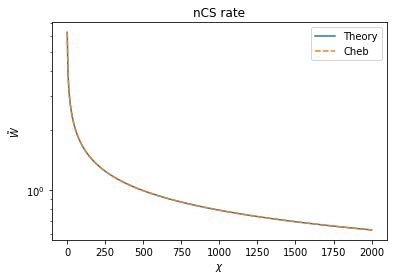

In [3]:
chiglst = np.linspace(0.5,2000,400)
Wlst = np.array([Wtildephtn(chig) for chig in chiglst])
Wlst_Cheb = np.array([Wtildephtn_Cheb(chig) for chig in chiglst])

plt.plot(chiglst, Wlst, label=r'Theory')
plt.plot(chiglst, Wlst_Cheb, '--', label=r'Cheb')
plt.yscale('log')
plt.title(r'nCS rate')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\tilde{W}$')
plt.legend()
#plt.savefig(r'nCS.pdf', transparent=True)
plt.show()

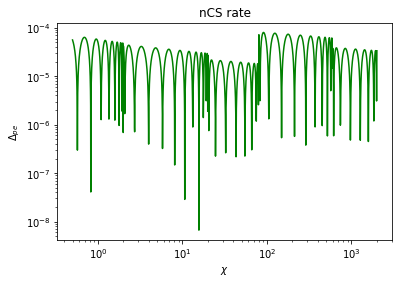

In [11]:
chiglst = np.logspace(np.log10(0.5),np.log10(2000-1e-3),2000)
deltaphtn = np.array([Deltaphtn(chig) for chig in chiglst])

plt.plot(chiglst, deltaphtn, 'g-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\Delta_{pe}$')
plt.title(r'nCS rate')
#plt.savefig(r'nCS_Delta.pdf', transparent=True)
plt.show()

# Figure 2: nBW rate

In [5]:
#fig2 compare double SFQED_BREIT_WHEELER_rate(double gamma, double chi)

# theory: eq 4.9
def Wtildepair(chig):
    return quad(lambda v: (9-v**2)/(3*(1-v**2))*kv(2/3,8/(3*chig*(1-v**2))), 0, 1 )[0]

def Wtildepair_Cheb(chig):
    a, b = 0, 1
    if 0.01<chig<=0.24:
        return (9*pi*chig)/(16*sqrt(2)) * exp(-8/(3*chig)) * (1- 11/64*chig + 7585*chig**2/73728) # should be asymptotic expression 4.10
    elif 0.24<chig<=0.4:    
        a, b = 0.24, 0.4
        coeff_file = "coefficients/pair_rate/pair_production_rate_024-04.txt"
    elif 0.3<chig<=2:
        a, b = 0.3, 2
        coeff_file = "coefficients/pair_rate/pair_production_rate_0-2.txt"
    elif 2<chig<=20:
        a, b = 2, 20
        coeff_file = "coefficients/pair_rate/pair_production_rate_2-20.txt"
    elif 20<chig<=80:
        a, b = 20, 80
        coeff_file = "coefficients/pair_rate/pair_production_rate_20-80.txt"
    elif 80<chig<=600:
        a, b = 80, 600
        coeff_file = "coefficients/pair_rate/pair_production_rate_80-600.txt"
    elif 600<chig<=2000:
        a, b = 600, 2000
        coeff_file = "coefficients/pair_rate/pair_production_rate_600-2000.txt"
    else:
        return 0
    coeffs = np.array(pd.read_csv(coeff_file)).flatten()[2:]
    X = (2*chig-a-b)/(b-a)
    
    res = np.polynomial.chebyshev.chebval(X, coeffs) # equivaelent to return np.sum(np.array([coeffs[n] * np.cos(n*np.arccos(X)) for n in range(len(coeffs))]))
    
    """
    # equivalent approach: Clenshaw’s recurrence
    N = len(coeffs)
    blst = np.zeros(N+2)
    for i in range(N):
        n = (N-1-i)
        blst[n] = coeffs[n] + 2*X*blst[n+1] - blst[n+2]
    return blst[0] - X*blst[1]
    """
    
    """
    # equivalent approach: Python version of Chebyshev_User_1D.h
    domain_middle_point = (a+b)/2
    domain_half_range = (b-a)/2
    y = (chig - domain_middle_point) / domain_half_range;
    #Clenshaw recurrence algorithm (easy peasy)
    #this stores the actual value that will be used in the algorithm
    y_alg = y * 2.;
    #define the first 2 coefficients of the Clenshaw series to 0.
    #(inside the algorithm loop we will update these two double variables,
    #whose names should be meaningful)
    tmp=0; clensh_j_plus_1 = 0.; clensh_j = 0.;
    evaluation_order = len(coeffs)
    jlst = np.arange(evaluation_order - 1, -1, -1)
    for j in jlst:
        # temporary save the j-th value of the new Clenshaw coefficient
        tmp = clensh_j;
        clensh_j = coeffs[j] - clensh_j_plus_1 + y_alg * clensh_j;
        clensh_j_plus_1 = tmp;
    #notice that at the end of the loop clensh_j_plus_1 will store clensh_1
    #while clensh_j will be equal to clensh_0
    #this statement returns the actual value of the approximation at the point x
    res = clensh_j - y * clensh_j_plus_1;"""
    
    return res

def Deltapp(chig):
    wtildepair = Wtildepair(chig)
    wtildepair_Cheb = Wtildepair_Cheb(chig)
    return np.abs((wtildepair-wtildepair_Cheb)/(wtildepair))

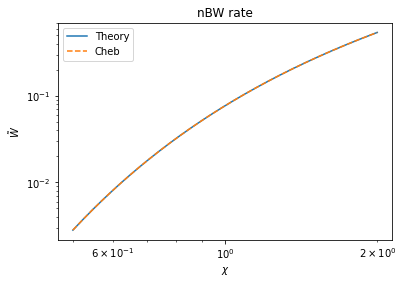

In [6]:
chiglst = np.linspace(0.5,2,400)
Wlst = np.array([Wtildepair(chig) for chig in chiglst])
Wlst_Cheb = np.array([Wtildepair_Cheb(chig) for chig in chiglst])

plt.plot(chiglst, Wlst, label=r'Theory')
plt.plot(chiglst, Wlst_Cheb, '--', label=r'Cheb')
plt.xscale('log')
#plt.yscale('symlog')
plt.yscale('log')
plt.legend()
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\tilde{W}$')
plt.title(r'nBW rate')
#plt.savefig(r'nBW.pdf', transparent=True)
plt.show()

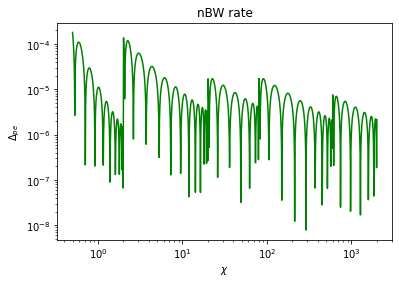

In [10]:
chiglst = np.logspace(np.log10(0.5),np.log10(2000-1e-3),2000)
deltapp = np.array([Deltapp(chig) for chig in chiglst])

plt.plot(chiglst, deltapp, 'g-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\chi$')
plt.ylabel(r'$\Delta_{pe}$')
plt.title(r'nBW rate')
#plt.savefig(r'nBW_Delta.pdf', transparent=True)
plt.show()